<a href="https://colab.research.google.com/github/ColeJMitchell/machine-learning-stock-prediction/blob/main/stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dependencies For The Project

In [34]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler

Testing Using Apple Ticker And Performing Exploratory Data Analysis

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.632530  129.395518  122.742873  128.782649  112117500
2023-01-04  124.907715  127.181283  123.642427  125.431622   89113600
2023-01-05  123.583115  126.301508  123.326108  125.668865   80962700
2023-01-06  128.130249  128.792547  123.454616  124.561746   87754700
2023-01-09  128.654129  131.876670  128.397123  128.970458   70790800
---------------------------------------------------------------------
Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   250.000000  250.000000  250.000000  250.000000  2.500000e+02
mean    171.093881  172.391078  169.540437  170.804350  5.921703e+07
std      17.399658   17.331272   17.598674   17.596275  1.777392e+07
min     123.583115  126.3

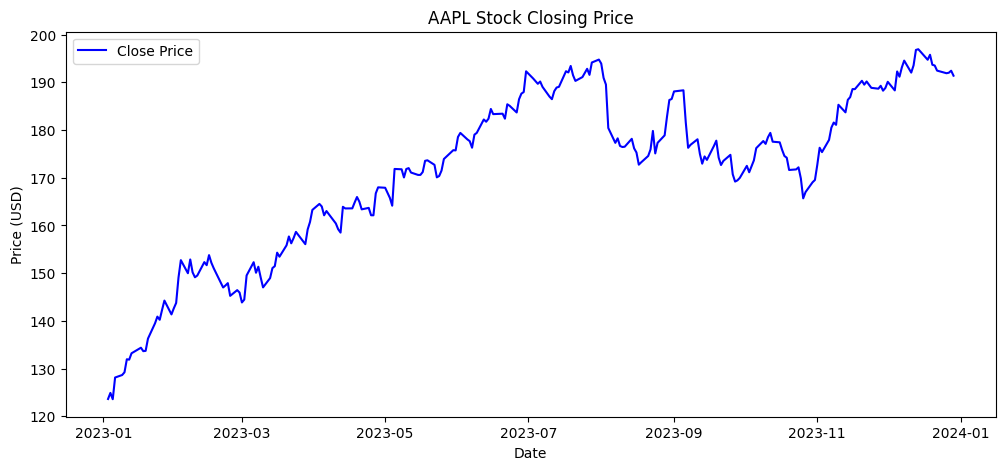

In [11]:
# API call to download Apple stock data
ticker = "AAPL"
df = yf.download(ticker, start="2023-01-01", end="2024-01-01")
print(df.head())
print("---------------------------------------------------------------------")

print(df.describe())
print("---------------------------------------------------------------------")

# Plot of trend in closing price
plt.figure(figsize=(12, 5))
plt.plot(df["Close"], label="Close Price", color='blue')
plt.title(f"{ticker} Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
print("\n")

In [86]:
# Dependencies for the LSTM model
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
!pip install gputil
import GPUtil as GPU
from IPython.display import clear_output
clear_output()

In [5]:
# Ensure a GPU is available before running the model
GPUs = GPU.getGPUs()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
  gpu = GPUs[0]

Num GPUs Available:  0


Load the stock tickers from the updates ticker text file found in the data directory of the project

In [40]:
stock_tickers = []
dates = []
with open("updated_tickers.txt", "r") as f:
  for line in f:
    parts = line.split("/", 1)
    # Get rid of some wrong tickers and keep a list of the post times for the sentiment analysis model
    if parts[0].strip() != "None" and parts[0].strip != "NONE" and parts[0].strip().upper() not in stock_tickers and parts[0].strip().isalpha():
      stock_tickers.append(parts[0].strip().upper())
      dt = datetime.datetime.utcfromtimestamp(float(parts[1].strip()))
      dates.append(dt.strftime('%Y-%m-%d'))

print(stock_tickers[:10])
print(dates[:10])

['AAPL', 'NVDA', 'MSTR', 'MP', 'PG', 'GLD', 'TSLA', 'AMC', 'META', 'HIMS']
['2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-16', '2025-04-15']


Get corresponding stock data from yahoo finance for each of the stock tickers

In [55]:
all_data = []
for ticker in stock_tickers:
    df = yf.download(ticker, start='2020-01-01', end='2025-01-01')
    df["Ticker"] = ticker
    all_data.append(df)

# Combine ticker data into one DataFrame
final_df = pd.concat(all_data)
clear_output()
print(final_df.head())

Price           Close       High        Low       Open       Volume Ticker  \
Ticker           AAPL       AAPL       AAPL       AAPL         AAPL          
Date                                                                         
2020-01-02  72.716072  72.776598  71.466812  71.721019  135480400.0   AAPL   
2020-01-03  72.009125  72.771752  71.783969  71.941336  146322800.0   AAPL   
2020-01-06  72.582886  72.621623  70.876053  71.127844  118387200.0   AAPL   
2020-01-07  72.241547  72.849224  72.021231  72.592594  108872000.0   AAPL   
2020-01-08  73.403648  73.706279  71.943759  71.943759  132079200.0   AAPL   

Price      Close High  Low Open  ... High  Low Open Volume Adj Close Close  \
Ticker      NVDA NVDA NVDA NVDA  ... NONE NONE NONE   NONE       FED   FED   
Date                             ...                                         
2020-01-02   NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN    NaN       NaN   NaN   
2020-01-03   NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN    NaN     

Pull closing stock data from the dataframe for each ticker and then apply normalization. Finally split the data in training, validation and test sets.

In [88]:
unique_tickers = final_df["Ticker"].unique()
total_data = []
# Add the closing prices for each of the tickers for the last five years
for ticker in unique_tickers:
  ticker_data = final_df[final_df["Ticker"] == ticker]["Close"].values
  if ticker_data.size > 0:
    total_data.append(ticker_data)

# First normalize the data then append it to a numpy array
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = []
for entry in total_data:
  entry = entry[~np.isnan(entry)]
  if entry.size == 0:
        continue
  # Min max scalar expects a 2d array
  reshaped_entry = entry.reshape(-1, 1)
  temp = scaler.fit_transform(reshaped_entry)
  normalized_data.append(temp.squeeze())

normalized_data = np.array(normalized_data, dtype=object)
normalized_data = pad_sequences(normalized_data, padding='post', dtype='float32')
print(normalized_data.shape)
print(normalized_data[:10])
print(f"Total Dataset Size: {len(normalized_data)}")

# Because stock data for five years the training data is split 90%/10% and this is 90% of the entire dataset. The test set is the remaining 10%.
training_and_validation_length = int(.9 * len(normalized_data))
train_length = int(.9 * training_and_validation_length)
train_set = normalized_data[:train_length]
val_set = normalized_data[train_length:training_and_validation_length]
test_set = normalized_data[training_and_validation_length:]
print(f"Training Set Size: {len(train_set)}")
print(f"Validation Set Size: {len(val_set)}")
print(f"Test Set Size: {len(test_set)}")

(67, 1258)
[[0.08941495 0.08595437 0.08876299 ... 0.9832283  0.96665215 0.95794845]
 [0.00750316 0.00683917 0.00701035 ... 0.9176276  0.9209615  0.89873576]
 [0.01121586 0.01105659 0.01120294 ... 0.69042856 0.6322292  0.60351694]
 ...
 [0.11504281 0.11280942 0.10961889 ... 0.00245574 0.00240759 0.00242364]
 [0.22150548 0.21947132 0.22667341 ... 0.94047064 0.9247052  0.9141645 ]
 [0.21818766 0.21818766 0.21818766 ... 0.7535347  0.7088689  0.67705655]]
Total Dataset Size: 67
Training Set Size: 54
Validation Set Size: 6
Test Set Size: 7


This LSTM model is the baseline which predicts how the stock will react without using any sentiment analysis.

In [9]:
# Defining the structure for an LSTM model that will be used to predict the change in the stock price a week after the post is made
model = keras.Sequential([
  # The model is trained at 28 time steps (1 each day over 4 weeks) and each day has 4 features: the open price, close price, low price, and high price.

  # The first LSTM layer
  keras.layers.LSTM(64, input_shape = (28, 4), return_sequences=True),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("tanh"),

  # The second LSTM layer
  keras.layers.LSTM(32),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("tanh"),

  # First dense layer after LSTM layers
  keras.layers.Dense(16, activation="relu"),

  # Regularization to prevent overfitting
  keras.layers.Dropout(.5),

  # Second dense layer
  keras.layers.Dense(16, activation="relu"),

  # Output layer should be a binary classification with a single neuron
  keras.layers.Dense(1, activation = "sigmoid")
]
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
